# **Session 4: Implementing and Solving a Nurse Rostering Problem with Python**

### **Overview**
In this session, we will focus on **Nurse Rostering** and implementing and solving mathematical programs using **SCIP**. We will start by implementing and solving the **Simple Scheduling Model**, which introduces the fundamental structure of workforce scheduling. Then, we will use this model to determine areas for improvement in the shift plan.  

### **Problem Description (from the lecture)**
We consider a **hospital emergency unit** that is **open from 8 AM – 7 PM**. The **goal is to schedule nurses** efficiently while:
- **Minimizing costs**.
- **Ensuring that all staffing requirements are met**.
- **Assigning nurses to shifts while respecting shift constraints**.

#### **Given Data:**
- The hospital operates **5 different shifts**.
- There is a **varying need for nurses** throughout the day.
- Each nurse can be **assigned to only one shift per day**.


### **Mathematical Model**
We define:

#### **Sets and Indices**
- \( I \) : Time intervals within a given cycle, e.g., in days or weeks (the length of time intervals may differ) for which personal needs to be scheduled, index \(i, i = 1,...,m\)
- \( S \) : Shift patterns, index \(j, j = 1,...,n\)

#### **Parameters**
- \( b_i \) : Number of persons required in interval \(i\)
- \( c_j \) : Cost of assigning a nurse to shift \( j \).
- \(a_{1j},a_{2j},...,a_{mj}\) : Shift pattern with \(a_{ij}=1\) if time interval \(i\) is a work period in shift \(j\), and 0 otherwise.

#### **Decision Variables**
- \( x_j \) : **Number of nurses assigned to shift** \( j \) (integer).

#### **Objective Function**
Minimize the total cost of scheduling nurses:
$$
\min \sum_{j \in S} c_j x_j
$$

#### **Constraints**
1. **Shift Coverage Constraint**: Each shift must be staffed with at least the required number of nurses:
   $$
   \sum_{j=1}^n a_{ij}\cdot x_j \geq b_i, \quad \forall j \in 1,...,m
   $$

2. **Non-Negativity Constraint**:
   $$
   x_j \in N, \quad \forall j \in 1,..,n
   $$

📌 **Now, let's implement this model in SCIP.**



⏳ Time to Solve: 0.00 seconds

✅ Optimal Solution Found!
👩‍⚕️ 5 nurses assigned to Shift 1
👩‍⚕️ 0 nurses assigned to Shift 2
👩‍⚕️ 8 nurses assigned to Shift 3
👩‍⚕️ 5 nurses assigned to Shift 4
👩‍⚕️ 1 nurses assigned to Shift 5

💰 **Total Cost of Staffing: 1400.00**


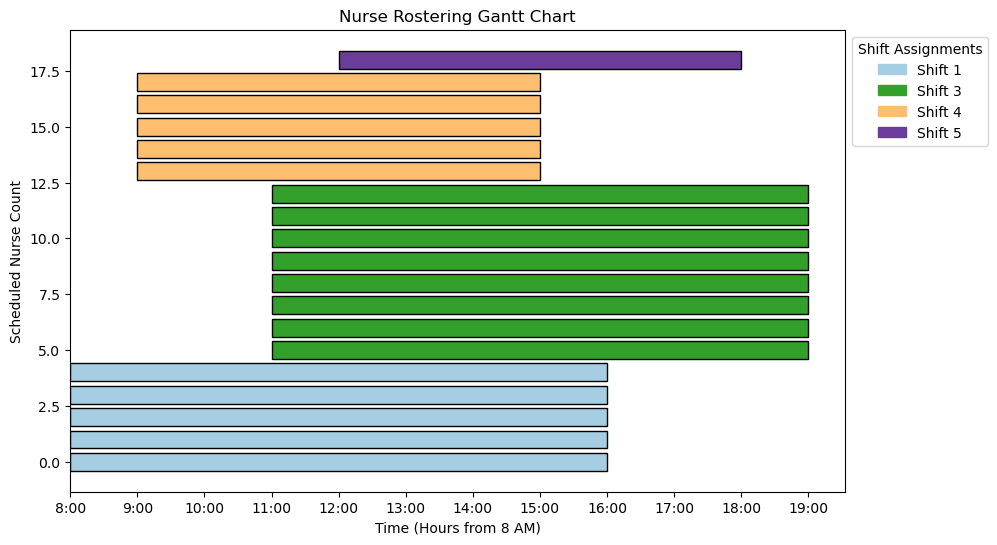

In [1]:
from pyscipopt import Model, quicksum
from helpers.plots import plot_simple_shift_schedule
import time 

# ✅ Step 1: Define the Data

# Number of shifts and time intervals
num_shifts = 5  
num_intervals = 11  

# Time intervals during the workday
time_intervals = [
    "8am-9am", "9am-10am", "10am-11am", "11am-12pm", "12pm-1pm",
    "1pm-2pm", "2pm-3pm", "3pm-4pm", "4pm-5pm", "5pm-6pm", "6pm-7pm"
]

# Shift names
shifts = [f"Shift {i}" for i in range(1, num_shifts + 1)]

# ✅ Demand for nurses in each time interval
nurse_demand = {
    "8am-9am": 5,  "9am-10am": 10, "10am-11am": 8, "11am-12pm": 6,
    "12pm-1pm": 5, "1pm-2pm": 5, "2pm-3pm": 6, "3pm-4pm": 6,
    "4pm-5pm": 8, "5pm-6pm": 9, "6pm-7pm": 8
}

# ✅ Cost per nurse for each shift
shift_costs = {
    "Shift 1": 80, "Shift 2": 70, "Shift 3": 80,
    "Shift 4": 60, "Shift 5": 60
}

# ✅ Shift Coverage Matrix (A[i][j] = 1 if shift j covers time interval i)
shift_patterns = [
    [1, 0, 0, 0, 0],  # 8am-9am
    [1, 0, 0, 1, 0],  # 9am-10am
    [1, 1, 0, 1, 0],  # 10am-11am
    [1, 1, 1, 1, 0],  # 11am-12pm
    [1, 1, 1, 1, 1],  # 12pm-1pm
    [1, 1, 1, 1, 1],  # 1pm-2pm
    [1, 1, 1, 1, 1],  # 2pm-3pm
    [1, 1, 1, 0, 1],  # 3pm-4pm
    [0, 1, 1, 0, 1],  # 4pm-5pm
    [0, 1, 1, 0, 1],  # 5pm-6pm
    [0, 0, 1, 0, 0]   # 6pm-7pm
]

# ✅ Step 2: Initialize SCIP Model
model = Model("SimpleShiftScheduling")

# ✅ Step 3: Define Decision Variables
# x[j] = Number of nurses assigned to shift j
x = {j: model.addVar(vtype="I", name=f"x_{j}") for j in shifts}

# ✅ Step 4: Add Constraints
# Ensure that each time interval has enough nurses scheduled
for i, interval in enumerate(time_intervals):
    model.addCons(
        quicksum(x[shifts[j]] * shift_patterns[i][j] for j in range(num_shifts)) >= nurse_demand[interval],
        name=f"coverage_{interval}"
    )

# ✅ Step 5: Set Objective Function (Minimize Staffing Cost)
model.setObjective(quicksum(shift_costs[j] * x[j] for j in shifts), "minimize")

# ✅ Step 6: Solve the Model
model.setParam("display/verblevel", 4)  # Enable detailed SCIP solver logging
start_time = time.time()
model.optimize()
solve_time = time.time() - start_time
print(f"\n⏳ Time to Solve: {solve_time:.2f} seconds")
# ✅ Step 7: Extract and Print Results
if model.getStatus() == "optimal":
    total_cost = model.getObjVal()  # Get the total cost from the optimal solution
    print("\n✅ Optimal Solution Found!")
    
    for j in shifts:
        num_nurses = model.getVal(x[j])
        print(f"👩‍⚕️ {num_nurses:.0f} nurses assigned to {j}")
    print(f"\n💰 **Total Cost of Staffing: {total_cost:.2f}**")
    plot_simple_shift_schedule(shifts, model, x)
else:
    print("⚠️ No optimal solution found.")


### **Task 1: Introducing a Split Shift (8 AM – 12 PM and 6 PM – 8 PM)**

#### **Problem Extension**
Some nurses are now willing to work a **split shift**, meaning:
- They **work from 8 AM – 12 PM**, then have a break, and **return from 6 PM – 8 PM**.
- This counts as **one shift** for scheduling purposes.
- The nurses present the new shift to the managament asking for 60 per shift. 

The newly proposed **split shift (8 AM – 12 PM & 6 PM – 8 PM)** is particularly appealing to **nurses with small children**, as it allows them a break in the middle of the day. However, this shift pattern is **new for the hospital management**, and they are hesitant to introduce it without a financial incentive.

#### **Task**
1. **Modify the shift structure** to add the **split shift (8 AM – 12 PM and 6 PM – 8 PM)**.
2. **Adjust the shift coverage matrix** to reflect the split shift.
3. **Define the cost for the new split shift**.
4. **Re-implement the optimization model** and solve it.
5. **Compare the results before and after adding the split shift**.

📌 **Do you think the management should agree to the new shift model?**



✅ Optimal Solution Found!
👩‍⚕️ -0 nurses assigned to Shift 1
👩‍⚕️ -0 nurses assigned to Shift 2
👩‍⚕️ 0 nurses assigned to Shift 3
👩‍⚕️ 0 nurses assigned to Shift 4
👩‍⚕️ 8 nurses assigned to Shift 5
👩‍⚕️ 10 nurses assigned to Split Shift

💰 **Total Cost of Staffing: 980.00**


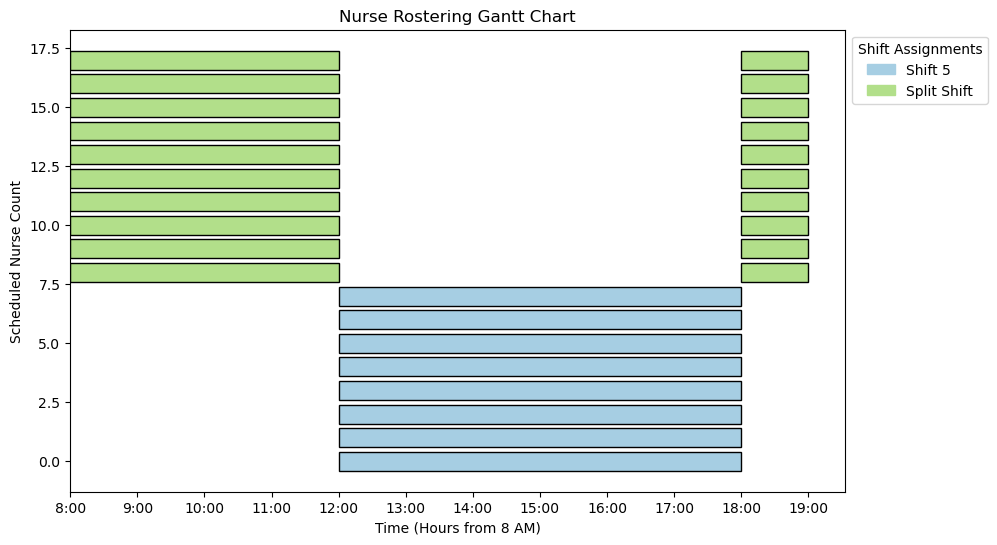

In [ ]:
from pyscipopt import Model, quicksum

# ✅ Step 1: Define the Updated Data

# Updated number of shifts (now 6 including the split shift)
num_shifts = 6  
num_intervals = 11  

# Time intervals remain the same
time_intervals = [
    "8am-9am", "9am-10am", "10am-11am", "11am-12pm", "12pm-1pm",
    "1pm-2pm", "2pm-3pm", "3pm-4pm", "4pm-5pm", "5pm-6pm", "6pm-7pm"
]

# Updated shift names including the split shift
shifts = [f"Shift {i}" for i in range(1, 6)] + ["Split Shift"]

# ✅ Updated demand for nurses per time interval
nurse_demand = {
    "8am-9am": 5,  "9am-10am": 10, "10am-11am": 8, "11am-12pm": 6,
    "12pm-1pm": 5, "1pm-2pm": 5, "2pm-3pm": 6, "3pm-4pm": 6,
    "4pm-5pm": 8, "5pm-6pm": 9, "6pm-7pm": 8
}


# ✅ Updated cost per shift
shift_costs = { "Shift 1": 80, "Shift 2": 70, "Shift 3": 80,
    "Shift 4": 60, "Shift 5": 60,
    "Split Shift": 120  # Cost for split shift (8-12 & 6-8)
}

# ✅ Updated Shift Coverage Matrix
# Now includes the new split shift covering (8-12) and (6-8)
shift_patterns = [
    [1, 0, 0, 0, 0, 1],  # 8am-9am
    [1, 0, 0, 1, 0, 1],  # 9am-10am
    [1, 1, 0, 1, 0, 1],  # 10am-11am
    [1, 1, 1, 1, 0, 1],  # 11am-12pm
    [1, 1, 1, 1, 1, 0],  # 12pm-1pm
    [1, 1, 1, 1, 1, 0],  # 1pm-2pm
    [1, 1, 1, 1, 1, 0],  # 2pm-3pm
    [1, 1, 1, 0, 1, 0],  # 3pm-4pm
    [0, 1, 1, 0, 1, 0],  # 4pm-5pm
    [0, 1, 1, 0, 1, 1],  # 5pm-6pm
    [0, 0, 1, 0, 0, 1]   # 6pm-7pm
]

# ✅ Step 2: Initialize SCIP Model
model = Model("ShiftSchedulingWithSplitShift")

# ✅ Step 3: Define Decision Variables
# x[j] = Number of nurses assigned to shift j
x = {j: model.addVar(vtype="I", name=f"x_{j}") for j in shifts}

# ✅ Step 4: Add Constraints
# Ensure that each time interval has enough nurses scheduled
for i, interval in enumerate(time_intervals):
    model.addCons(
        quicksum(x[shifts[j]] * shift_patterns[i][j] for j in range(num_shifts)) >= nurse_demand[interval],
        name=f"coverage_{interval}"
    )

# ✅ Step 5: Set Objective Function (Minimize Staffing Cost)
model.setObjective(quicksum(shift_costs[j] * x[j] for j in shifts), "minimize")

# ✅ Step 6: Solve the Model
model.setParam("display/verblevel", 4)  # Enable detailed SCIP solver logging
model.optimize()

# ✅ Step 7: Extract and Print Results
if model.getStatus() == "optimal":
    total_cost = model.getObjVal()  # Get the total cost from the optimal solution
    print("\n✅ Optimal Solution Found!")

    for j in shifts:
        num_nurses = model.getVal(x[j])
        print(f"👩‍⚕️ {num_nurses:.0f} nurses assigned to {j}")
    print(f"\n💰 **Total Cost of Staffing: {total_cost:.2f}**")
    plot_simple_shift_schedule(shifts, model, x)
else:
    print("⚠️ No optimal solution found.")


## **Task 2: Maximum Acceptable Cost for the Split Shift**

You can see that the managament should agree to the new split shift model. Now, assume that you are representing the nurses who, while benefiting from the new flexibility are still inconvenienced by having to travel to the hospital for work twice a day now. They want to demand more pay for this shift reflecting the extra commuiting hours. What is the maximum amount that they can charge for the shift so that the managementw will still agree to introduce the new pattern? 

In [ ]:
# Your turn! Copy what you need from the above model to this cell and modify the parameters to answer the question!

## **Bonus Task 3: Maximizing Pay per Hour**

Given the constraints and objectives of nurse scheduling, what **shift pattern** should a nurse propose to management in order to **maximize her pay per hour**?  

Justify your answer based on the given scheduling framework.


In [ ]:
# Your turn! Copy what you need from the above model to this cell and modify the parameters to answer the question!